<a href="https://colab.research.google.com/github/Ivelina-Z/Plant-disease-detection/blob/main/plant_disease_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import tensorflow as tf

In [25]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Softmax
from tensorflow.keras.applications import resnet50
from tensorflow.keras.optimizers import Adam

In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime
import random

In [27]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


<h1 align=center> Tomato plants disease detection </h1>

The task of that project is to create a model, capable of detecting certain diseases of a tomato plants. The data provided consists of labeled images, including the classes below:

*   Bacterial_spot
*   Early_blight
*   Late_blight
*   Leaf_Mold
*   Septoria_leaf_spot
*   Spider_mites Two-spotted_spider_mite
*   Target_Spot
*   Tomato_Yellow_Leaf_Curl_Virus
*   Tomato_mosaic_virus
*   healthy

To achieve the task a transfer learning with already trained model (ResNet 50) will be used.

## Custom functions

In [28]:
def get_folder_paths(directory):
  folder_names = sorted(os.listdir(directory))
  folder_paths = sorted([os.path.join(directory, name) for name in folder_names])
  return folder_names, folder_paths

### data pipeline functions

In [29]:
def read_image(image_filename, image_class):
  image_result = tf.io.read_file(image_filename)
  image = tf.image.decode_jpeg(image_result, channels=3)
  image_resized = tf.image.resize(image, IMAGE_SIZE)
  image_preprocessed = resnet50.preprocess_input(image_resized)
  return image_preprocessed, image_class

In [30]:
def create_tf_dataset(data: tuple, batch_size, image_size):
  """
    This function creates tf Dataset from input data with the specified batch_size
    and resizes the images, according to the image_size argument.
    The input data should be a tuple with image filename and image class.
  """

  def read_image(image_filename, image_class):
    image_result = tf.io.read_file(image_filename)
    image = tf.image.decode_jpeg(image_result, channels=3)

    image_resized = tf.image.resize(image, IMAGE_SIZE)

    image_preprocessed = resnet50.preprocess_input(image_resized)
    return image_preprocessed, image_class

  tf_dataset = tf.data.Dataset \
    .from_tensor_slices(data) \
    .shuffle(len(files_train)) \
    .map(read_image) \
    .batch(batch_size)

  return tf_dataset

## Set TensorBoard

In [31]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [32]:
logdir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(logdir + "/metrics")
file_writer.set_as_default()

In [33]:
tf.random.set_seed(13)
random.seed(13)

## Read files

The data is divided into two folders. The files in `image` folder are used for train, validation and evaluation of the model, after splitting the data. It consists of 4535 images, which are relatively equally distributed throught the classes. In `manual_testing` folder 5 images of each class are set aside for manual testing with augmentation of the images at the evaluation step.

The structure of each folder is as follows:

*   Image
    *   Tomato___Bacterial_spot
      *   Img_1
      *   Img_2
      *   Img_N
    *   Tomato___Early_blight
      *   Img_1
      *   Img_2
      *   Img_N
    *   Tomato___Late_blight
    *   Tomato___Leaf_Mold
    *   Tomato___Septoria_leaf_spot
    *   Tomato___Spider_mites Two-spotted_spider_mite
    *   Tomato___Target_Spot
    *   Tomato___Tomato_Yellow_Leaf_Curl_Virus
    *   Tomato___Tomato_mosaic_virus
    *   Tomato___healthy

*   Manual_testing


In [34]:
MAIN_DIR = '/content/gdrive/MyDrive/datasets/plant_disease_dataset/image'
MANUAL_TEST_DIR = '/content/gdrive/MyDrive/datasets/plant_disease_dataset/manual_testing'

In [35]:
folder_names, folder_paths = get_folder_paths(MAIN_DIR)
folder_paths

['/content/gdrive/MyDrive/datasets/plant_disease_dataset/image/Tomato___Bacterial_spot',
 '/content/gdrive/MyDrive/datasets/plant_disease_dataset/image/Tomato___Early_blight',
 '/content/gdrive/MyDrive/datasets/plant_disease_dataset/image/Tomato___Late_blight',
 '/content/gdrive/MyDrive/datasets/plant_disease_dataset/image/Tomato___Leaf_Mold',
 '/content/gdrive/MyDrive/datasets/plant_disease_dataset/image/Tomato___Septoria_leaf_spot',
 '/content/gdrive/MyDrive/datasets/plant_disease_dataset/image/Tomato___Spider_mites Two-spotted_spider_mite',
 '/content/gdrive/MyDrive/datasets/plant_disease_dataset/image/Tomato___Target_Spot',
 '/content/gdrive/MyDrive/datasets/plant_disease_dataset/image/Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 '/content/gdrive/MyDrive/datasets/plant_disease_dataset/image/Tomato___Tomato_mosaic_virus',
 '/content/gdrive/MyDrive/datasets/plant_disease_dataset/image/Tomato___healthy']

In [36]:
class_names = {label: name.split('___')[-1] for label, name in enumerate(folder_names)}
class_names

{0: 'Bacterial_spot',
 1: 'Early_blight',
 2: 'Late_blight',
 3: 'Leaf_Mold',
 4: 'Septoria_leaf_spot',
 5: 'Spider_mites Two-spotted_spider_mite',
 6: 'Target_Spot',
 7: 'Tomato_Yellow_Leaf_Curl_Virus',
 8: 'Tomato_mosaic_virus',
 9: 'healthy'}

In [37]:
sum([len(os.listdir(p)) for p in folder_paths])

4535

In [38]:
{p: len(os.listdir(p)) for p in folder_paths}

{'/content/gdrive/MyDrive/datasets/plant_disease_dataset/image/Tomato___Bacterial_spot': 420,
 '/content/gdrive/MyDrive/datasets/plant_disease_dataset/image/Tomato___Early_blight': 475,
 '/content/gdrive/MyDrive/datasets/plant_disease_dataset/image/Tomato___Late_blight': 458,
 '/content/gdrive/MyDrive/datasets/plant_disease_dataset/image/Tomato___Leaf_Mold': 465,
 '/content/gdrive/MyDrive/datasets/plant_disease_dataset/image/Tomato___Septoria_leaf_spot': 431,
 '/content/gdrive/MyDrive/datasets/plant_disease_dataset/image/Tomato___Spider_mites Two-spotted_spider_mite': 430,
 '/content/gdrive/MyDrive/datasets/plant_disease_dataset/image/Tomato___Target_Spot': 452,
 '/content/gdrive/MyDrive/datasets/plant_disease_dataset/image/Tomato___Tomato_Yellow_Leaf_Curl_Virus': 485,
 '/content/gdrive/MyDrive/datasets/plant_disease_dataset/image/Tomato___Tomato_mosaic_virus': 443,
 '/content/gdrive/MyDrive/datasets/plant_disease_dataset/image/Tomato___healthy': 476}

## Train, test, validation split

The data in `image` folder is splitted to train, test and validation datasets.
10% of the data is set aside for model testing. The other 90% are used in the training step, 80% - for train data and 10% for validation. 
The resulting datasets are stratified by the labels. 

In [39]:
files_train = []
classes_train = []
files_test = []
classes_test = []
files_val = []
classes_val = []

In [40]:
for label, folder_path in enumerate(folder_paths): 
  image_names = os.listdir(folder_path)
  image_path = [os.path.join(folder_paths[label], name) for name in image_names]
  
  test_size = int(len(image_names) * 0.1)
  validation_size = int(len(image_names) * 0.1)
  train_size = len(image_names) - test_size - validation_size

  files_test.extend(image_path[:test_size])
  classes_test.extend([label] * test_size)

  files_val.extend(image_path[test_size:(test_size + validation_size)])
  classes_val.extend([label] * validation_size)

  files_train.extend(image_path[test_size + validation_size:])
  classes_train.extend([label] * train_size)

In [41]:
assert len(files_train) == len(classes_train)
assert len(files_test) == len(classes_test)
assert len(files_val) == len(classes_val)
assert(not set(classes_train).difference(set(class_names.keys())))
assert(not set(classes_test).difference(set(class_names.keys())))
assert(not set(classes_val).difference(set(class_names.keys())))

## Input data pipeline

The input data pipeline receives the images' file paths with the corresponfing class, a batch size and image size and returns a tensorflow dataset. 
In between the images are red and decoded from the already shuffled paths. The model that's used needs certain size of the input images (244x244). The resizing is done in the pipeline. The specific preprocessing for ResNet 50 is also applied. At the end batches with certain size are made.

In [42]:
IMAGE_SIZE = [224, 224]
BATCH_SIZE = 4

In [43]:
train_data = create_tf_dataset((files_train, classes_train), BATCH_SIZE, IMAGE_SIZE)
val_data = create_tf_dataset((files_val, classes_val), BATCH_SIZE, IMAGE_SIZE)
test_data = create_tf_dataset((files_test, classes_test), BATCH_SIZE, IMAGE_SIZE)

## Batch visualisation

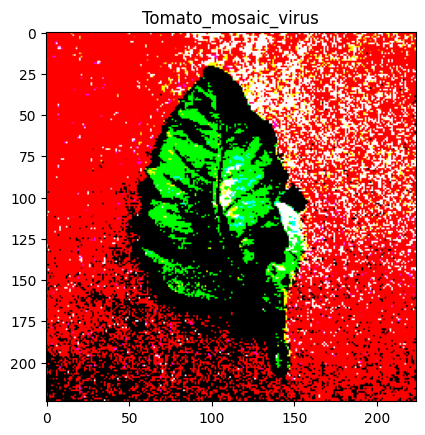

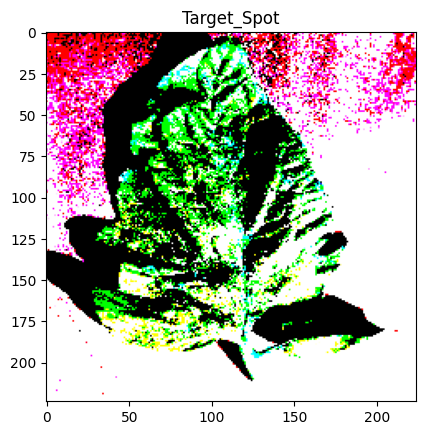

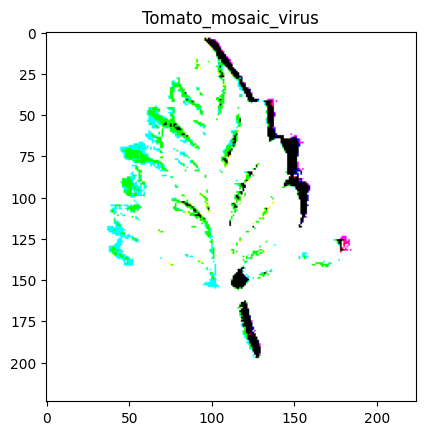

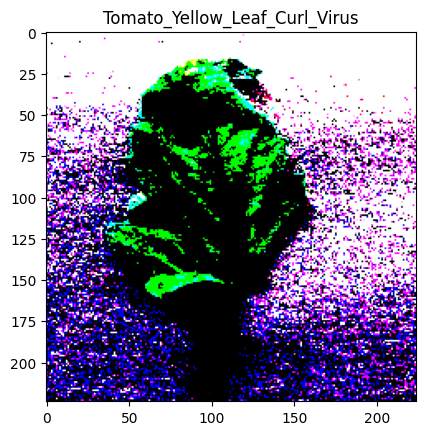

In [44]:
for el in train_data.take(1):
  for idx in range(BATCH_SIZE):
    plt.figure()
    plt.imshow(el[0][idx].numpy())
    plt.title(class_names[el[1][idx].numpy()])

### Model 

In [45]:
model = resnet50.ResNet50()

102967424/102967424 [==============================] - 1s 0us/step


In [46]:
model.trainable = False

In [47]:
def create_model():
  conv_head = Model(inputs = model.input, outputs = model.layers[-2].output)
  dense_1 = Dense(64, activation = 'relu')(conv_head.output)
  dropout_layer = Dropout(0.1)(dense_1)
  dense_2 = Dense(16, activation = 'relu')(dropout_layer)
  output_dense = Dense(10)(dense_2)
  new_model = Model(inputs = conv_head.input, outputs = output_dense)
  return new_model

In [48]:
new_model = create_model()
new_model.compile(optimizer=Adam(learning_rate = 1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [49]:
history = new_model.fit(
    train_data,
    epochs=5,
    validation_data = val_data
)

Epoch 1/5
418/909 [============>.................] - ETA: 4:16 - loss: 1.5036 - accuracy: 0.4426

KeyboardInterrupt: ignored